In [67]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima

import prophet

warnings.filterwarnings('ignore')

In [68]:
mat = np.empty((0, 5))
metrics = pd.DataFrame(mat)
metrics = pd.DataFrame(columns=['country', 'model', 'mae', 'mape', 'rsq'])

# Belgium

## Model 1

### Train/Test Split

In [69]:
df = pd.read_csv('multivar.csv') 
df = df[df['location'] == 'Belgium']
df = df.drop(columns=['iso_code'])
df = df.drop(columns=['location'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [70]:
categorical_cols = ['continent', 'tests_units', 'season']
df = pd.get_dummies(df, columns=categorical_cols)

In [71]:
train_size = int(len(df) * 0.7)
train, test = df[0:train_size], df[train_size:]
print(train.shape, test.shape)

(141, 53) (61, 53)


In [72]:
X_train = train.drop(columns=['new_deaths']) 
X_test = test.drop(columns=['new_deaths']) 
y_train = train['new_deaths']
y_test = test['new_deaths']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(141, 52) (141,) (61, 52) (61,)


### Model 

In [73]:
reg = xgb.XGBRegressor(learning_rate=0.3,n_estimators=1000, early_stopping_rounds=10)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=True)

[14:32:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:307.45496	validation_1-rmse:25.46827
[1]	validation_0-rmse:230.37181	validation_1-rmse:19.15237
[2]	validation_0-rmse:174.49573	validation_1-rmse:14.91985
[3]	validation_0-rmse:134.06145	validation_1-rmse:11.50975
[4]	validation_0-rmse:104.01422	validation_1-rmse:10.04814
[5]	validation_0-rmse:81.06626	validation_1-rmse:9.12848
[6]	validation_0-rmse:63.50701	validation_1-rmse:8.70675
[7]	validation_0-rmse:50.02302	validation_1-rmse:8.68636
[8]	validation_0-rmse:39.76551	validation_1-rmse:8.491

[93]	validation_0-rmse:0.00294	validation_1-rmse:8.74176
[94]	validation_0-rmse:0.00274	validation_1-rmse:8.74180
[95]	validation_0-rmse:0.00258	validation_1-rmse:8.74182
[96]	validation_0-rmse:0.00243	validation_1-rmse:8.74188
[97]	validation_0-rmse:0.00231	validation_1-rmse:8.74156
[98]	validation_0-rmse:0.00221	validation_1-rmse:8.74156
[99]	validation_0-rmse:0.00206	validation_1-rmse:8.74148
[100]	validation_0-rmse:0.00195	validation_1-rmse:8.74119
[101]	validation_0-rmse:0.00189	validation_1-rmse:8.74122
[102]	validation_0-rmse:0.00182	validation_1-rmse:8.74123
[103]	validation_0-rmse:0.00160	validation_1-rmse:8.74131
[104]	validation_0-rmse:0.00152	validation_1-rmse:8.74139
[105]	validation_0-rmse:0.00131	validation_1-rmse:8.74142
[106]	validation_0-rmse:0.00125	validation_1-rmse:8.74142
[107]	validation_0-rmse:0.00113	validation_1-rmse:8.74151
[108]	validation_0-rmse:0.00104	validation_1-rmse:8.74152
[109]	validation_0-rmse:0.00095	validation_1-rmse:8.74150
[110]	validation_0-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

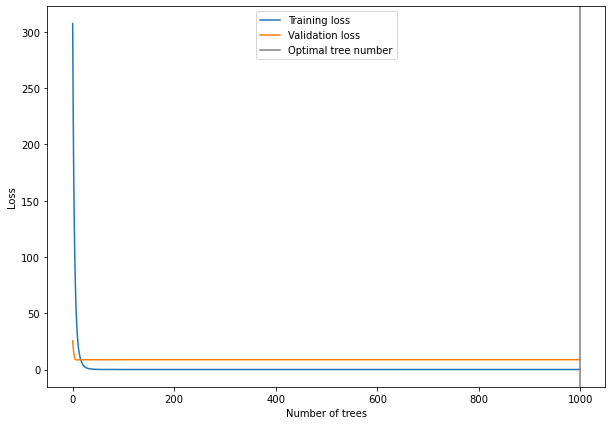

In [74]:
results = reg.evals_result()


plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [75]:
reg.best_iteration

999

### Feature Importance

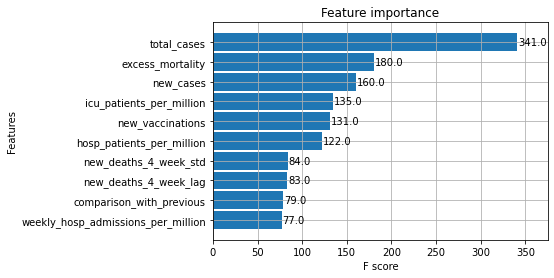

In [76]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

### Forcast on Test Set

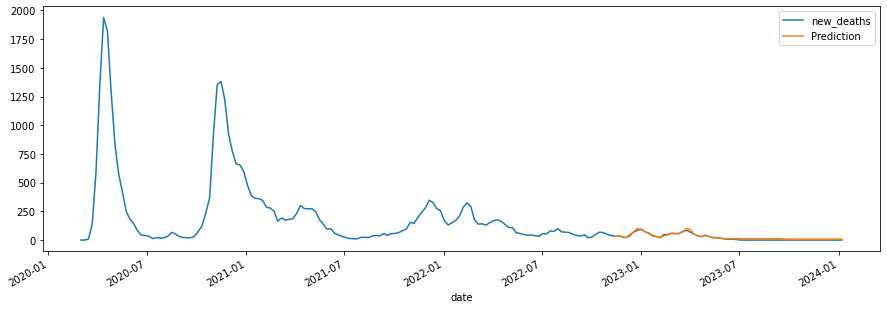

In [77]:
test['Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([test, train], sort=False)
_ = pjme_all[['new_deaths','Prediction']].plot(figsize=(15, 5))

### Metrics

In [78]:
mae = mean_absolute_error(test['new_deaths'], test['Prediction'])
mape = mean_absolute_percentage_error(test['new_deaths'], test['Prediction'])
r2 = r2_score(test['new_deaths'], test['Prediction'])
new_row = {'country': 'Belgium', 'model': '1', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## Model 2

### Train/Test Split

In [79]:
df = pd.read_csv('multivar.csv') 
df = df[df['location'] == 'Belgium']
df = df[['total_cases', 'excess_mortality', 'new_cases', 'icu_patients_per_million','new_vaccinations',
         'hosp_patients_per_million', 'new_deaths_4_week_std', 'new_deaths_4_week_lag',
         'comparison_with_previous', 'weekly_hosp_admissions_per_million', 'date', 'new_deaths']]
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [80]:
train_size = int(len(df) * 0.7)
train, test = df[0:train_size], df[train_size:]
print(train.shape, test.shape)

(141, 11) (61, 11)


In [81]:
X_train = train.drop(columns=['new_deaths']) 
X_test = test.drop(columns=['new_deaths']) 
y_train = train['new_deaths']
y_test = test['new_deaths']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(141, 10) (141,) (61, 10) (61,)


### Model

In [82]:
reg = xgb.XGBRegressor(learning_rate=0.3,n_estimators=1000, early_stopping_rounds=10)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=True)

[14:32:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:309.86148	validation_1-rmse:26.47551
[1]	validation_0-rmse:234.37987	validation_1-rmse:20.66188
[2]	validation_0-rmse:179.18976	validation_1-rmse:15.51974
[3]	validation_0-rmse:138.35763	validation_1-rmse:13.85336
[4]	validation_0-rmse:108.59022	validation_1-rmse:15.18721
[5]	validation_0-rmse:85.46114	validation_1-rmse:15.32051
[6]	validation_0-rmse:67.56514	validation_1-rmse:16.13708
[7]	validation_0-rmse:53.43375	validation_1-rmse:16.98421
[8]	validation_0-rmse:42.49009	validation_1-rmse:17

[40]	validation_0-rmse:0.62618	validation_1-rmse:18.61314
[41]	validation_0-rmse:0.55410	validation_1-rmse:18.60549
[42]	validation_0-rmse:0.50700	validation_1-rmse:18.63031
[43]	validation_0-rmse:0.45124	validation_1-rmse:18.68645
[44]	validation_0-rmse:0.39819	validation_1-rmse:18.69582
[45]	validation_0-rmse:0.37220	validation_1-rmse:18.70205
[46]	validation_0-rmse:0.33887	validation_1-rmse:18.76225
[47]	validation_0-rmse:0.30203	validation_1-rmse:18.79234
[48]	validation_0-rmse:0.27838	validation_1-rmse:18.81450
[49]	validation_0-rmse:0.23900	validation_1-rmse:18.82898
[50]	validation_0-rmse:0.22976	validation_1-rmse:18.84896
[51]	validation_0-rmse:0.21368	validation_1-rmse:18.84333
[52]	validation_0-rmse:0.19385	validation_1-rmse:18.84362
[53]	validation_0-rmse:0.18371	validation_1-rmse:18.85073
[54]	validation_0-rmse:0.17675	validation_1-rmse:18.86712
[55]	validation_0-rmse:0.17135	validation_1-rmse:18.86895
[56]	validation_0-rmse:0.15344	validation_1-rmse:18.87082
[57]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

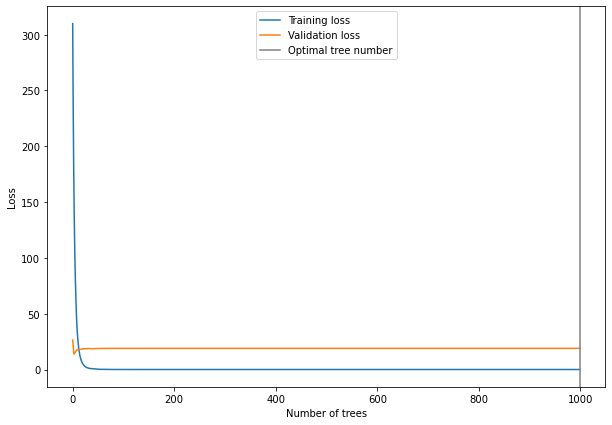

In [83]:
results = reg.evals_result()


plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [84]:
reg.best_iteration

999

### Forcast on Test Set

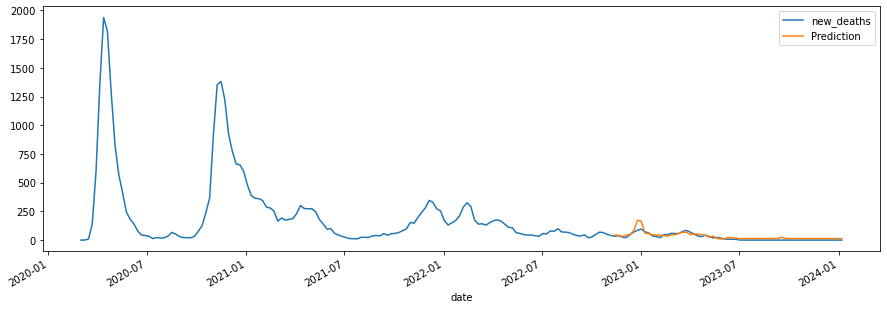

In [85]:
test['Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([test, train], sort=False)
_ = pjme_all[['new_deaths','Prediction']].plot(figsize=(15, 5))

### Metrics

In [86]:
mae = mean_absolute_error(test['new_deaths'], test['Prediction'])
mape = mean_absolute_percentage_error(test['new_deaths'], test['Prediction'])
r2 = r2_score(test['new_deaths'], test['Prediction'])
new_row = {'country': 'Belgium', 'model': '2', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Chile

## Model 1

### Train/Test Split 

In [89]:
df = pd.read_csv('multivar.csv') 
df = df[df['location'] == 'Chile']
df = df.drop(columns=['iso_code'])
df = df.drop(columns=['location'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

categorical_cols = ['continent', 'tests_units', 'season']
df = pd.get_dummies(df, columns=categorical_cols)

train_size = int(len(df) * 0.7)
train, test = df[0:train_size], df[train_size:]
print(train.shape, test.shape)

X_train = train.drop(columns=['new_deaths']) 
X_test = test.drop(columns=['new_deaths']) 
y_train = train['new_deaths']
y_test = test['new_deaths']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(141, 53) (61, 53)
(141, 52) (141,) (61, 52) (61,)


### Model

[14:38:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:913.39728	validation_1-rmse:62.05038
[1]	validation_0-rmse:763.63196	validation_1-rmse:45.46190
[2]	validation_0-rmse:641.35968	validation_1-rmse:35.51053
[3]	validation_0-rmse:540.54358	validation_1-rmse:32.77850
[4]	validation_0-rmse:456.07349	validation_1-rmse:29.49917
[5]	validation_0-rmse:385.73233	validation_1-rmse:29.05029
[6]	validation_0-rmse:326.65854	validation_1-rmse:28.06557
[7]	validation_0-rmse:276.67343	validation_1-rmse:27.73441
[8]	validation_0-rmse:234.50217	validation_1-rms

999

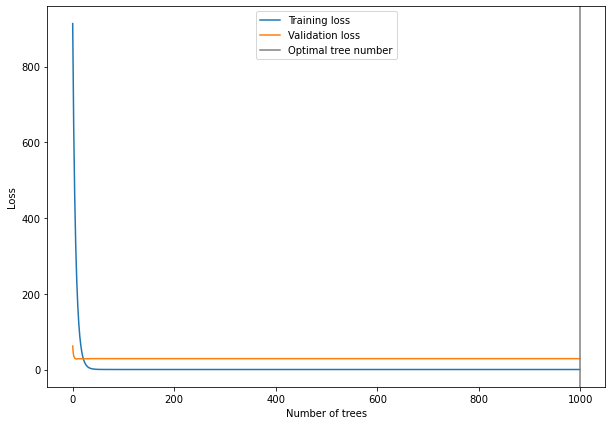

In [90]:
reg = xgb.XGBRegressor(learning_rate=0.3,n_estimators=1000, early_stopping_rounds=10)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=True)

results = reg.evals_result()


plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

reg.best_iteration

### Feature Importance

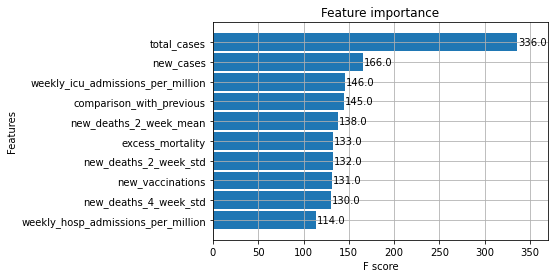

In [91]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

### Forcast on Test Set

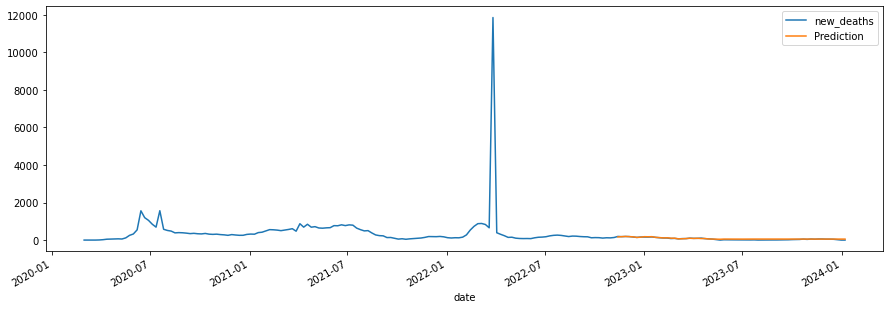

In [92]:
test['Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([test, train], sort=False)
_ = pjme_all[['new_deaths','Prediction']].plot(figsize=(15, 5))

### Metrics

In [93]:
mae = mean_absolute_error(test['new_deaths'], test['Prediction'])
mape = mean_absolute_percentage_error(test['new_deaths'], test['Prediction'])
r2 = r2_score(test['new_deaths'], test['Prediction'])
new_row = {'country': 'Chile', 'model': '1', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## Model 2

### Train/Test Split

### Model

### Forcast on Test Set

### Metrics

# Czechia

# Estonia

# France

# Ireland

# Israel

# Italy

# Malaysia

# United States